## Import Packages

In [2]:
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from keras.datasets import cifar10
from keras.utils import to_categorical

In [3]:
#Convolution Neural Networks Filter Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D,AveragePooling2D,BatchNormalization
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Concatenate ,Conv2DTranspose,Dropout
from keras import optimizers
from keras.models import Model
from keras import backend as K

In [4]:
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D ,LeakyReLU,ReLU, Concatenate,Flatten
from keras import optimizers
from keras.models import Model

## Load Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
# 정규화 사용 시 코드
# x_train=x_train.astype('float32')/255.
# x_test=x_test.astype('float32')/255.

In [7]:
y_train = to_categorical(y_train,10) #원핫 인코딩
y_test=to_categorical(y_test,10) #원핫 인코딩

## Train Test Split

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model : Densenet

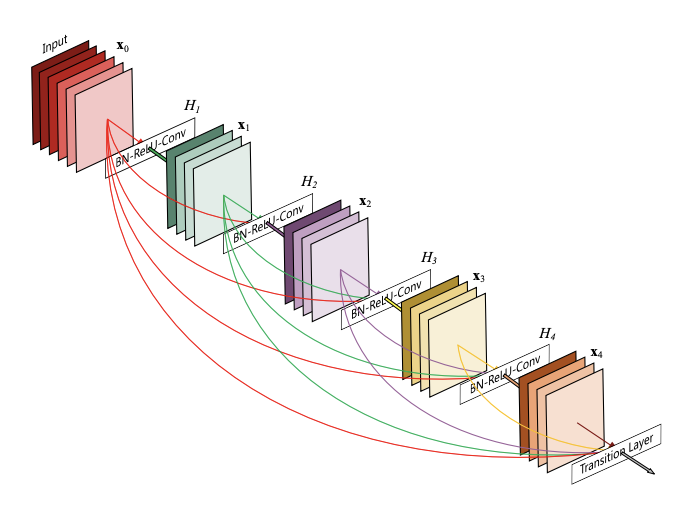

In [16]:
epochs = 10 #학습 반복 수
inChannel = 3 # 3채널 고정
x, y = 32, 32 # Width, Height
act=ReLU() #활성화 함수 변경 시 사용
n_class = 10 #클래스 수
lr=0.001 #learning rate
loss = 'categorical_crossentropy' #손실함수 
batch_size=64 #배치사이즈
#opt=optimizers.SGD(learning_rate=lr,momentum=0.9,nesterov=True)
opt=optimizers.Adam(learning_rate=lr)

In [10]:
import keras.layers as L
# 출처
# https://gist.github.com/A03ki/27ec0cec5aed24c335dcd463350b5041
class DenseNet:
    def __init__(self, blocks, growth_rate, dropout_rate=0.0, use_bias=True):
        self.blocks = blocks
        self.growth_rate = growth_rate
        self.dropout_rate = dropout_rate
        self.use_bias = use_bias

    def __call__(self, x, bottleneck=True, compression=0.5,
                 dataset="imagenet"):
        if (compression != 1.0 and bottleneck) or dataset == "imagenet":
            channels = self.growth_rate * 2
        else:
            channels = 16
        x = self.first_conv2d(x, channels, dataset)
        for i, n_blocks in enumerate(self.blocks):
            if i != 0:
                x = self.transition_layer(x, compression=compression)
            x = self.dense_block(x, n_blocks, bottleneck=bottleneck)
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)
        return L.GlobalAveragePooling2D()(x)

    def first_conv2d(self, x, channels, dataset):
        kernel_size = (7, 7) if dataset == "imagenet" else (3, 3)
        x = self._conv2d(x, channels, kernel_size)
        if dataset == "imagenet":
            x = L.BatchNormalization()(x)
            x = L.Activation("relu")(x)
            x = L.MaxPooling2D((3, 3), strides=2, padding="same")(x)
        return x

    def convolution_block(self, x, bottleneck=True):
        if bottleneck:
            x = self.bn_relu_conv2d(x, self.growth_rate * 4, (1, 1))
        return self.bn_relu_conv2d(x, self.growth_rate, (3, 3))

    def dense_block(self, x, n_blocks, bottleneck=True):
        for i in range(n_blocks):
            x = self._dense_block(x, bottleneck=bottleneck)
        return x

    def _dense_block(self, x, bottleneck=True):
        bypass = self.convolution_block(x, bottleneck=bottleneck)
        return L.Concatenate()([x, bypass])

    def transition_layer(self, x, compression=0.5):
        output_channels = int(x.shape[-1] * compression)
        x = self.bn_relu_conv2d(x, output_channels, (1, 1))
        return L.AveragePooling2D((2, 2))(x)

    def bn_relu_conv2d(self, x, output_channels, kernel):
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)
        return self._conv2d(x, output_channels, kernel,
                            dropout_rate=self.dropout_rate)

    def _conv2d(self, x, output_channels, kernel, padding="same",
                dropout_rate=0.0):
        x = L.Conv2D(output_channels, kernel, padding=padding,
                     use_bias=self.use_bias)(x)
        if dropout_rate:
            x = L.Dropout(dropout_rate)(x)
        return x

## F1-Score

In [11]:
#https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### DenseNet, DenseNet-B, DenseNet-C, DenseNet-BC 사용시 링크참고
### https://gist.github.com/A03ki/27ec0cec5aed24c335dcd463350b5041

### 층 개수에 따른 코드
### densenet = DenseNet([6, 12, 24, 16], 32, use_bias=False) DenseNet121
### densenet = DenseNet([6, 12, 32, 32], 32, use_bias=False) DenseNet169
### densenet = DenseNet([6, 12, 48, 32], 32, use_bias=False) DenseNet201

In [19]:
densenet121 = DenseNet([6, 12, 24, 16], 32, use_bias=False, dropout_rate=0.0)
input_img = L.Input((x, y, inChannel))
output = densenet121(input_img, dataset=None)
output = L.Dense(n_class, activation="softmax")(output)
densenet = Model(inputs=input_img, outputs=output)
densenet.compile(loss=loss, optimizer=opt,metrics=['accuracy',f1_score])
densenet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_360 (Conv2D)            (None, 32, 32, 64)   1728        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_360 (Batch  (None, 32, 32, 64)  256         ['conv2d_360[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_360 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_360[0

 Normalization)                                                                                   
                                                                                                  
 activation_369 (Activation)    (None, 32, 32, 128)  0           ['batch_normalization_369[0][0]']
                                                                                                  
 conv2d_370 (Conv2D)            (None, 32, 32, 32)   36864       ['activation_369[0][0]']         
                                                                                                  
 concatenate_178 (Concatenate)  (None, 32, 32, 224)  0           ['concatenate_177[0][0]',        
                                                                  'conv2d_370[0][0]']             
                                                                                                  
 batch_normalization_370 (Batch  (None, 32, 32, 224)  896        ['concatenate_178[0][0]']        
 Normaliza

                                                                                                  
 concatenate_182 (Concatenate)  (None, 16, 16, 224)  0           ['concatenate_181[0][0]',        
                                                                  'conv2d_379[0][0]']             
                                                                                                  
 batch_normalization_379 (Batch  (None, 16, 16, 224)  896        ['concatenate_182[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_379 (Activation)    (None, 16, 16, 224)  0           ['batch_normalization_379[0][0]']
                                                                                                  
 conv2d_380 (Conv2D)            (None, 16, 16, 128)  28672       ['activation_379[0][0]']         
          

                                                                                                  
 conv2d_389 (Conv2D)            (None, 16, 16, 32)   36864       ['activation_388[0][0]']         
                                                                                                  
 concatenate_187 (Concatenate)  (None, 16, 16, 384)  0           ['concatenate_186[0][0]',        
                                                                  'conv2d_389[0][0]']             
                                                                                                  
 batch_normalization_389 (Batch  (None, 16, 16, 384)  1536       ['concatenate_187[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_389 (Activation)    (None, 16, 16, 384)  0           ['batch_normalization_389[0][0]']
          

                                                                                                  
 batch_normalization_398 (Batch  (None, 8, 8, 256)   1024        ['average_pooling2d_10[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 activation_398 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_398[0][0]']
                                                                                                  
 conv2d_399 (Conv2D)            (None, 8, 8, 128)    32768       ['activation_398[0][0]']         
                                                                                                  
 batch_normalization_399 (Batch  (None, 8, 8, 128)   512         ['conv2d_399[0][0]']             
 Normalization)                                                                                   
          

 concatenate_196 (Concatenate)  (None, 8, 8, 416)    0           ['concatenate_195[0][0]',        
                                                                  'conv2d_408[0][0]']             
                                                                                                  
 batch_normalization_408 (Batch  (None, 8, 8, 416)   1664        ['concatenate_196[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_408 (Activation)    (None, 8, 8, 416)    0           ['batch_normalization_408[0][0]']
                                                                                                  
 conv2d_409 (Conv2D)            (None, 8, 8, 128)    53248       ['activation_408[0][0]']         
                                                                                                  
 batch_nor

 conv2d_418 (Conv2D)            (None, 8, 8, 32)     36864       ['activation_417[0][0]']         
                                                                                                  
 concatenate_201 (Concatenate)  (None, 8, 8, 576)    0           ['concatenate_200[0][0]',        
                                                                  'conv2d_418[0][0]']             
                                                                                                  
 batch_normalization_418 (Batch  (None, 8, 8, 576)   2304        ['concatenate_201[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_418 (Activation)    (None, 8, 8, 576)    0           ['batch_normalization_418[0][0]']
                                                                                                  
 conv2d_41

 activation_427 (Activation)    (None, 8, 8, 128)    0           ['batch_normalization_427[0][0]']
                                                                                                  
 conv2d_428 (Conv2D)            (None, 8, 8, 32)     36864       ['activation_427[0][0]']         
                                                                                                  
 concatenate_206 (Concatenate)  (None, 8, 8, 736)    0           ['concatenate_205[0][0]',        
                                                                  'conv2d_428[0][0]']             
                                                                                                  
 batch_normalization_428 (Batch  (None, 8, 8, 736)   2944        ['concatenate_206[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 activation_437 (Activation)    (None, 8, 8, 128)    0           ['batch_normalization_437[0][0]']
                                                                                                  
 conv2d_438 (Conv2D)            (None, 8, 8, 32)     36864       ['activation_437[0][0]']         
                                                                                                  
 concatenate_211 (Concatenate)  (None, 8, 8, 896)    0           ['concatenate_210[0][0]',        
                                                                  'conv2d_438[0][0]']             
                                                                                                  
 batch_normalization_438 (Batch  (None, 8, 8, 896)   3584        ['concatenate_211[0][0]']        
 Normaliza

                                                                                                  
 average_pooling2d_11 (AverageP  (None, 4, 4, 512)   0           ['conv2d_447[0][0]']             
 ooling2D)                                                                                        
                                                                                                  
 batch_normalization_447 (Batch  (None, 4, 4, 512)   2048        ['average_pooling2d_11[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 activation_447 (Activation)    (None, 4, 4, 512)    0           ['batch_normalization_447[0][0]']
                                                                                                  
 conv2d_448 (Conv2D)            (None, 4, 4, 128)    65536       ['activation_447[0][0]']         
          

                                                                                                  
 conv2d_457 (Conv2D)            (None, 4, 4, 32)     36864       ['activation_456[0][0]']         
                                                                                                  
 concatenate_220 (Concatenate)  (None, 4, 4, 672)    0           ['concatenate_219[0][0]',        
                                                                  'conv2d_457[0][0]']             
                                                                                                  
 batch_normalization_457 (Batch  (None, 4, 4, 672)   2688        ['concatenate_220[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_457 (Activation)    (None, 4, 4, 672)    0           ['batch_normalization_457[0][0]']
          

                                                                                                  
 activation_466 (Activation)    (None, 4, 4, 128)    0           ['batch_normalization_466[0][0]']
                                                                                                  
 conv2d_467 (Conv2D)            (None, 4, 4, 32)     36864       ['activation_466[0][0]']         
                                                                                                  
 concatenate_225 (Concatenate)  (None, 4, 4, 832)    0           ['concatenate_224[0][0]',        
                                                                  'conv2d_467[0][0]']             
                                                                                                  
 batch_normalization_467 (Batch  (None, 4, 4, 832)   3328        ['concatenate_225[0][0]']        
 Normalization)                                                                                   
          

 batch_normalization_476 (Batch  (None, 4, 4, 128)   512         ['conv2d_476[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_476 (Activation)    (None, 4, 4, 128)    0           ['batch_normalization_476[0][0]']
                                                                                                  
 conv2d_477 (Conv2D)            (None, 4, 4, 32)     36864       ['activation_476[0][0]']         
                                                                                                  
 concatenate_230 (Concatenate)  (None, 4, 4, 992)    0           ['concatenate_229[0][0]',        
                                                                  'conv2d_477[0][0]']             
                                                                                                  
 batch_nor

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
start = time.time()
densenet_train = densenet.fit(x_train, 
                      y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      verbose=2,
                      )
end = time.time()
running_time = end - start
print("소요시간 : "+str(running_time)+'초')

Epoch 1/10
782/782 - 70s - loss: 1.1993 - accuracy: 0.5693 - f1_score: 0.5176 - 70s/epoch - 90ms/step
Epoch 2/10
782/782 - 58s - loss: 0.7034 - accuracy: 0.7533 - f1_score: 0.7473 - 58s/epoch - 75ms/step
Epoch 3/10


KeyboardInterrupt: 

## Test Data 20 Class F1-Score

In [ ]:
pred= densenet.predict(x_test)

In [ ]:
densenet_loss = densenet_train.history['loss']
densenet_f1_score = densenet_train.history["f1_score"]
densenet_acc= densenet_train.history["accuracy"]
plt.figure()
plt.plot(range(epochs), densenet_loss, 'b', label="loss")
plt.plot(range(epochs), densenet_f1_score, 'r', label="f1_score")
plt.plot(range(epochs), densenet_acc, 'g', label="accuracy")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
#pred의 경우 50개의 값 중 가장 높은 predict값을 가지는 인덱스를 라벨(클래스)로 사용
y_pred=[]
y_true=[]
for i in range(len(pred)):
    tmp1 = pred[i].argmax() #최대값을 가지는 인덱스
    tmp2 = y_test[i].argmax() #최대값을 가지는 인덱스 -> 0과 1만 가지므로 1인 인덱스 반환
    y_pred.append(tmp1)
    y_true.append(tmp2)

In [ ]:
from sklearn.metrics import f1_score
print("각 클래스별 F1-Score의 평균: {0} ".format(f1_score(y_true, y_pred, average = None).mean()))

In [ ]:
print(metrics.confusion_matrix(y_true, y_pred))
print(metrics.classification_report(y_true, y_pred, digits=3))

In [ ]:
#evaluate = vgg16.evaluate(x_test,y_test,batch_size=batch_size)

In [ ]:
# accuracy=evaluate[1]
# f1_score=evaluate[2]
# print(accuracy)
# print(f1_score)